# Exploratory Data Analysis of Wildfires in Mexico from 1970 to 2023

<img src="https://media.licdn.com/dms/image/D4D03AQEnxU1bGqE73Q/profile-displayphoto-shrink_400_400/0/1678754238733?e=1722470400&v=beta&t=Kw7qF2f0hppi8H-VNTFkrWpXl0R1odG2lUuQc0e6kd4" alt="Profile" width="100" height="45" style="float: left; margin-right: 10px;">

## By: Carlos Varela

## Introduction

Wildfires are a critical environmental issue that impact ecosystems, wildlife, and the mexican communities. Understanding the patterns and trends in wildfire occurrences can help in developing effective strategies for prevention and management. This project focuses on the analysis of wildfire data in Mexico from 1970 to 2023. The dataset includes information on the number of wildfires, the area burned (in hectares), and the geographic distribution of these fires across various states and regions.

## Purpose of Exploratory Data Analysis (EDA)

EDA is a crucial step in the data analysis process. It involves examining the data in a systematic way to uncover underlying patterns, identify anomalies, test hypotheses, and check assumptions through summary statistics and graphical representations. The main objectives of EDA in this project are:

1. **Data Quality Assessment**: Evaluating the quality and completeness of the data to identify any issues that may need to be addressed before further analysis or modeling. 
2. **Understanding the Distribution of the Data**: Gaining insights into the distribution of the data. Profiling our set through bins, histograms and box plots.
3. **Identifying Trends and Patterns**: Analyzing temporal trends in forest fire occurrences and burned areas to understand how these have evolved over time.
4. **Seasonal Variations**: Investigating seasonal patterns in wildfire occurrences to determine if there is seasonality to the appearance or increase of fires.
5. **Correlation Analysis**: Exploring relationships between different variables, such as the number of fires and the area burned, to identify potential correlations.
6. **Modeling Analysis**: Examining if our dataset can be used to train a machine learning algorithm for regression tasks

By conducting EDA, we aim to build a solid understanding of the dataset, which will inform subsequent data processing, analysis, and modeling steps. Ultimately, the insights gained from this analysis can contribute to more effective wildfire management and prevention strategies.

In the following sections, we will perform a series of analyses using various statistical techniques and visualization tools to achieve these objectives.

In [3]:
# Importing necessary libraries:

import requests
import pandas as pd
from sqlalchemy import create_engine
import io
import numpy as np
import matplotlib.pyplot as plt
import os

## Data Extraction

For this project we will use a dataset of free-use lincense provided by the Government of Mexico located in this website: https://datos.gob.mx/busca/dataset/incendios-forestales/resource/f88e952a-852c-4615-ac18-d3a87811d529

The data was collected by "CONAFOR" or Comision Nacional Forestal, which is a department of the Mexican Federal Government that provides support from the "PRONAFOR" Program. It is a Decentralized Public Organization of SEMARNAT or "Secretariat of Environment and Natural Resources".

In [8]:
# Download dataset from download link:
download_url = "https://idefor.cnf.gob.mx/documents/933/download"

try:
    # Create directory:
    path = os.getcwd() + '/raw_data'
    os.mkdir(path) 

    download_response = requests.get(download_url)
    download_response.raise_for_status()

    # Write the content to a file
    with open('raw_data/downloaded_file.csv', 'wb') as file:
        file.write(download_response.content)

    print("File downloaded successfully.")
except Exception as error:
    print('Could not retrieve file. Encountered error: ', error)

File downloaded successfully.


## Data Loading

In [13]:
# Read data from csv using pandas:
raw_data = pd.read_csv('raw_data/downloaded_file.csv')
raw_data.head(5)

,"Gerencia De Manejo del Fuego, Diciembre 2022",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Año,Entidad Federativa,Cantidad de Incendios Forestales,Superficie quemada en ha,Región
1,1970,Chihuahua,301,50088,Norte
2,1970,Chiapas,97,15395,Sureste
3,1970,Guanajuato,10,12801,Occidente
4,1970,México,906,11514,Centro


## Data preprocessing

Looks like our data needs some preprocessing... Next we will: 
- Inspect for duplicated records
- Inspect for null values
- Remove the header 
- Translate the column names
- Lowercasing every string value

In [14]:
# Ignoring csv header:
raw_data = pd.read_csv('downloaded_file.csv', header=1)
preprocessed_data = raw_data.copy() # In case we need the original file...

# Convert all string data in the dataframe to lowercase
preprocessed_data = preprocessed_data.applymap(lambda x: x.lower() if type(x) == str else x)

# Translate column names to English
new_columns = {'Año':'year', 
               'Entidad Federativa':'state', 
               'Cantidad de Incendios Forestales':'number_of_fires', 
               'Superficie quemada en ha':'burned_area_ha', 
               'Región':'region'}

# Rename columns
preprocessed_data = preprocessed_data.rename(columns=new_columns)

preprocessed_data.head(5)

,year,state,number_of_fires,burned_area_ha,region
0,1970,chihuahua,301,50088.0,norte
1,1970,chiapas,97,15395.0,sureste
2,1970,guanajuato,10,12801.0,occidente
3,1970,méxico,906,11514.0,centro
4,1970,oaxaca,106,9516.0,centro


In [15]:
# Identifying null values:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             1728 non-null   int64  
 1   state            1728 non-null   object 
 2   number_of_fires  1728 non-null   int64  
 3   burned_area_ha   1728 non-null   float64
 4   region           1728 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 67.6+ KB


Excellent, it appears that not a single column contains null values.

In [16]:
# Removing duplicates:
if preprocessed_data.duplicated().sum() > 0:
    preprocessed_data.dropna()
    print('Duplicated records deleted')
else:
    print('No duplicates found')

No duplicates found


Now we can wrangle the data much easier.

**Initial Assessment**

Our dataset consists of 5 columns. These present information regarding wildfires from 1970 to 2021, accross the mexican territory. The columns are:

- **year**: The year in which the recorded fires occured
- **state:** The state in which the wildfire occured
- **number_of_fires:** cuantitative measure of how many fires occured per state
- **burned_area_ha**: The amount of land that was consumed by the fire, in hectares
- **region:** The region from the mexican territory to which each record corresponds

In [17]:
# Translating the regions:
regions = preprocessed_data['region'].unique()
regions

array(['norte', 'sureste', 'occidente', 'centro', 'noreste', 'noroeste'],
      dtype=object)

In [18]:
regions_to_translate = {
    'norte': 'north', 
    'sureste': 'southeast', 
    'occidente': 'west', 
    'centro': 'mainland', 
    'noreste': 'northeast', 
    'noroeste': 'northwest'
}

# Use map to assign the new values to each region:
preprocessed_data['region'] = preprocessed_data['region'].map(regions_to_translate)
print(preprocessed_data['region'].unique())
print()
preprocessed_data.head(5)

['north' 'southeast' 'west' 'mainland' 'northeast' 'northwest']



,year,state,number_of_fires,burned_area_ha,region
0,1970,chihuahua,301,50088.0,north
1,1970,chiapas,97,15395.0,southeast
2,1970,guanajuato,10,12801.0,west
3,1970,méxico,906,11514.0,mainland
4,1970,oaxaca,106,9516.0,mainland


We now have a dataframe ready for analysis. We will start by:
- Obtaining some descriptive statistics
- Observing the distribution of the data (bins & histograms)
- Identifying patterns or trends
- Correlation analysis

## Exploratory Data Analysis 1.0 - Descriptive statistics

In [9]:
# Creating a copy in case we need our preprocessed dataframe...
wildfires_df = preprocessed_data.copy()

In [10]:
wildfires_df[['number_of_fires','burned_area_ha']].describe()

,number_of_fires,burned_area_ha
count,1728.000000,1728.000000
mean,221.269097,9188.331314
std,391.228115,20862.756469
min,0.000000,0.000000
25%,23.000000,747.000000
50%,80.000000,2778.000000
75%,239.500000,9461.000000
max,4748.000000,424541.000000


We can already obtain some insights from our cohort.

**Speaking about fires:**

- On average, there are approximately 221 forest fires per state (for this cohort) per year
- The standard deviation is 391.23, which suggests a high level of variability in the number of fires across different states and years. This indicates that while some states have relatively few fires, others have many more
- There are instances where no fires were reported
- Historically (1970-2021) 25% of the observations have 23 or fewer fires, showing that a quarter of the data points are relatively low in terms of fire occurrences.
- The median number of fires is 80, meaning that half of the states have 80 or fewer fires per year, and half have more. This is a more robust measure of central tendency than the mean, especially given the high variability
- The top 25% of the data points have more than 239.5 fires, showing that a significant number of states experience a high number of fires
- The maximum number of fires recorded in any state in any year is 4,748. This outlier indicates that certain states in certain years experience an extraordinarily high number of fires compared to the average

Following up, we will split the data by decades and create bins. These metrics might be more significant by doing so...

## Exploratory Data Analysis 1.1 - Profiling

In [11]:
# Define the bins for decades:
bins = [1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels = ['1970s', '1980s', '1990s', '2000s', '2010s', '2020s']

# Create a decade column:
wildfires_df['decade'] = pd.cut(wildfires_df['year'], bins=bins, labels=labels, right=False)

# Group by the decade and sum the number of fires:
wildfires_per_decade = wildfires_df.groupby('decade')['number_of_fires'].sum().reset_index()
wildfires_per_decade

,decade,number_of_fires
0,1970s,51292
1,1980s,67807
2,1990s,77677
3,2000s,81315
4,2010s,76646
5,2020s,27616


**Comparing decade activity using boxplots**

A great way to compare descriptive statistics between groups is to use boxplots. These help us visualize high-level information instantly since they offer general information about:
- Data symmetry
- skew
- variance
- outliers

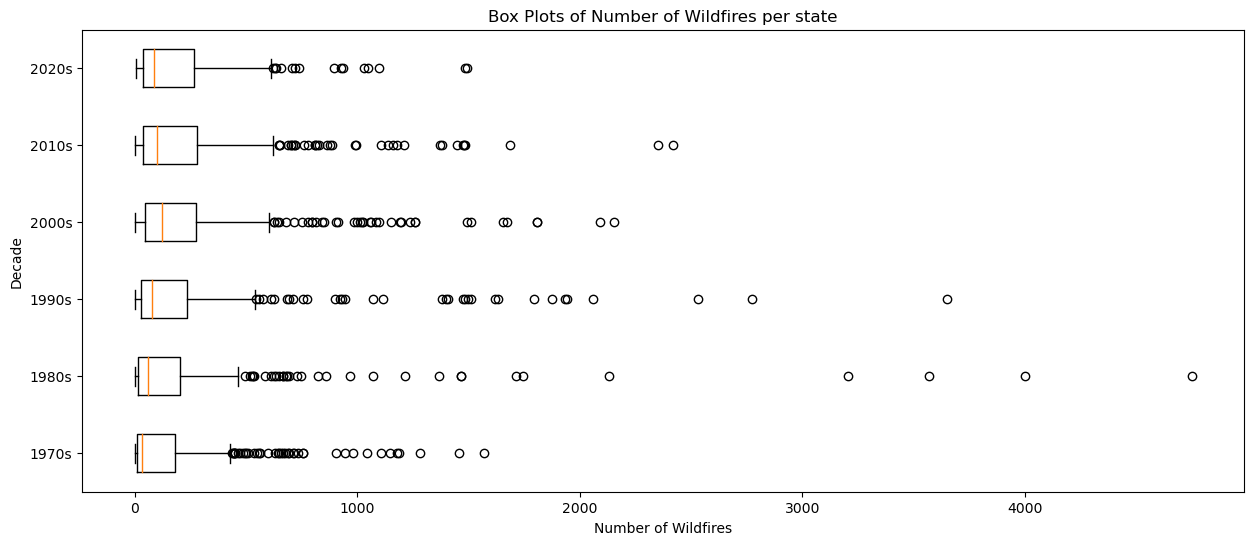

In [12]:
# Creating dataframes for each decade:
df_1970s = wildfires_df[wildfires_df['decade'] == '1970s']
df_1980s = wildfires_df[wildfires_df['decade'] == '1980s']
df_1990s = wildfires_df[wildfires_df['decade'] == '1990s']
df_2000s = wildfires_df[wildfires_df['decade'] == '2000s']
df_2010s = wildfires_df[wildfires_df['decade'] == '2010s']
df_2020s = wildfires_df[wildfires_df['decade'] == '2020s']

# Creating dictionary of decade and number of fires per state:
decades_dict = {
    '1970s': df_1970s['number_of_fires'].tolist(),
    '1980s': df_1980s['number_of_fires'].tolist(),
    '1990s': df_1990s['number_of_fires'].tolist(),
    '2000s': df_2000s['number_of_fires'].tolist(),
    '2010s': df_2010s['number_of_fires'].tolist(),
    '2020s': df_2020s['number_of_fires'].tolist()
}

# Plotting box plots for each group:
fig, ax = plt.subplots(figsize=(15, 6))
ax.boxplot(decades_dict.values(), vert=False)

# Adding title and labels:
ax.set_title('Box Plots of Number of Wildfires per state')
ax.set_yticklabels(decades_dict.keys())
ax.set_ylabel('Decade')
ax.set_xlabel('Number of Wildfires')

# Display the plot
plt.show()

**Interpretation:**

Rising Central Tendency from the 70s to the 00s:

- The median represents the middle value of the dataset, meaning that half of the states have a number of wildfires above the median and half below.
- An increasing median across decades indicates that the central value of wildfire incidents is going up, suggesting a general increase in the typical number of wildfires experienced by states.
- However, from the 00s onward, the central tendency appears to decrease slightly. This suggests a general decrease in the typical number of wildfires experienced by states.

Increase in variability

- The width of the box (IQR) indicates the spread of the middle 50% of the data. The increasing size of the box plots per decade indicates that there has been an increase in the variability or spread of the number of wildfires per state. This means that the difference between states with relatively few and many wildfires is growing.

Right-Skewed Distribution:

- The box plot being skewed to the right with a long tail and many outliers on the right side suggests a right-skewed distribution. This means that while most states have relatively low to moderate numbers of wildfires, a few states have a significantly higher number of wildfires.

Central Tendency:

- The median (central line in the box) is closer to the lower quartile (25th percentile), indicating that half of the states have a relatively low number of wildfires, but the other half includes states with much higher numbers, pulling the distribution to the right.

Variability and Spread:

- The slight increase in the width of the lower whiskers suggests that there is a small but growing variability in the lower range of wildfire incidents among the states.
- The increasing width of the upper whiskers indicates that the variability in the higher range is also increasing, and this is more pronounced than in the lower range.

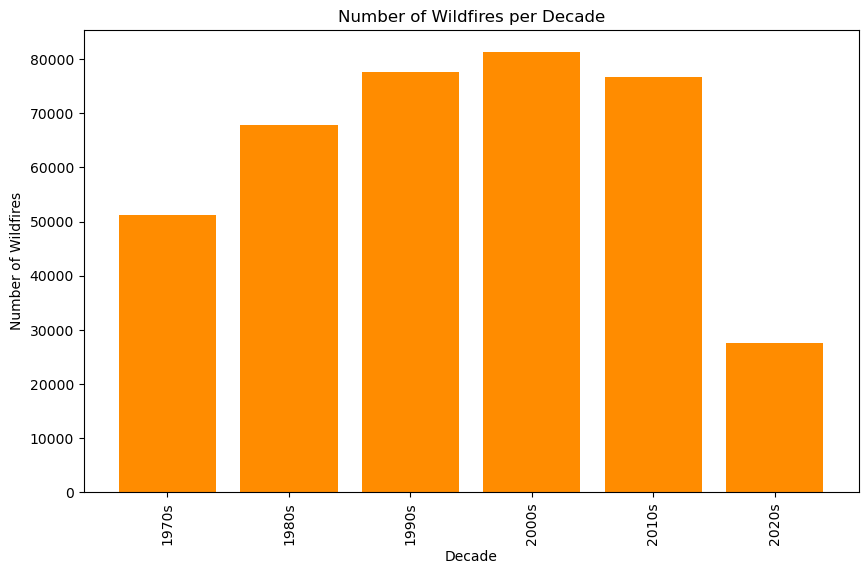

In [13]:
# Function to plot bar chart:
def bar_plot(x, height, xlabel, ylabel, title):
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(x, height, color='darkorange')
    
    # Adding labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability

    # Display the plot
    plt.show()

# Testing our function:
bar_plot(
    wildfires_per_decade['decade'], 
    wildfires_per_decade['number_of_fires'],
    'Decade',
    'Number of Wildfires',
    'Number of Wildfires per Decade'
)

From this plot we can observe that the number of wildfires per decade has increased. Although in ther 2010s, the activity decreased slightly. We can consider that the number of wildfires since the 1990s has remained within the same levels. For the 2020s, there is only data up to 2024, which explains the drop in fires. 

**Further analysis**

A next step would be to explore if there are key influencers driving the increase in fires per decade. We can analyze which states drive higher fire rates by decade and identify if there is any pattern.

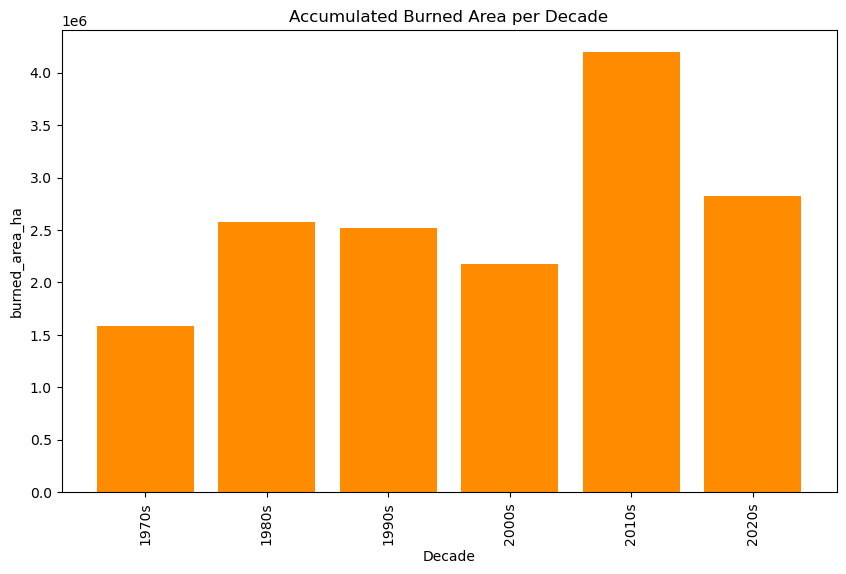

In [14]:
# Group by the decade and sum the burned areas:
burned_area_per_decade = wildfires_df.groupby('decade')['burned_area_ha'].sum().reset_index()
burned_area_per_decade

bar_plot(
    burned_area_per_decade['decade'], 
    burned_area_per_decade['burned_area_ha'],
    'Decade',
    'burned_area_ha',
    'Accumulated Burned Area per Decade'
)

**Profiling states by number of fires**

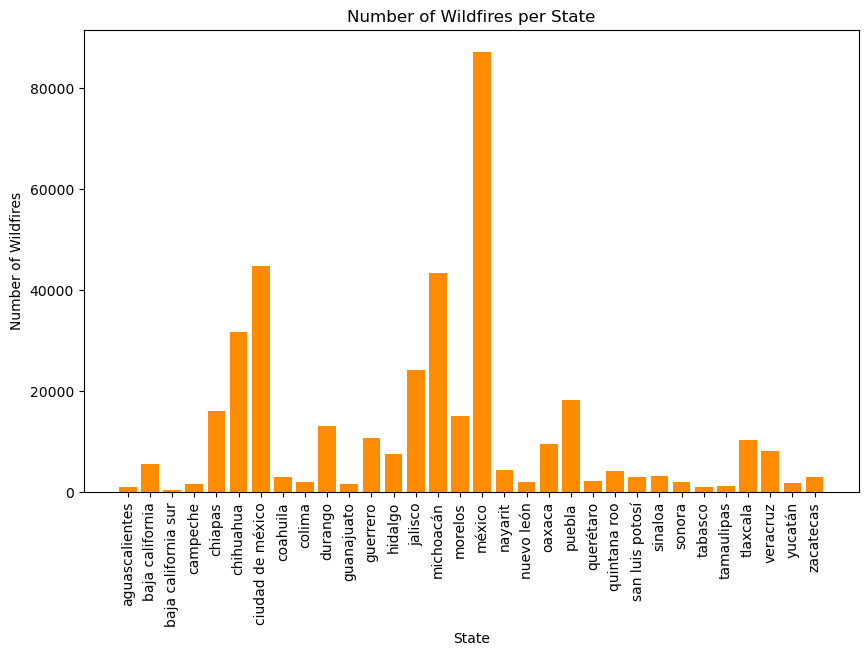

In [15]:
# Group by the state and sum the number of fires:
wildfires_per_state = wildfires_df.groupby('state')['number_of_fires'].sum().reset_index()

bar_plot(
    wildfires_per_state['state'], 
    wildfires_per_state['number_of_fires'],
    'State',
    'Number of Wildfires',
    'Number of Wildfires per State'
)

From the bar chart, we can observe the historical count of wildfires per state. Historically, the state of mexico seems to be the state that accounts for more fires officialy reported within this cohort. Meanwile, Baja California Sur seems to be the state with lower fires reported.

While this could support that some states accoiunt for more fires in general, more information on the quality and integrity of the dataset is required to support this claim.

**Quick note**

As we can see, the state of mexico appears to behave like an outlier when it comes to number of fires historically. More news on this topic can be found here:
https://smn.conagua.gob.mx/es/incendios-forestales-diario#:~:text=Las%20entidades%20federativas%20con%20mayor%20presencia%20de%20INCENDIOS%20fueron%3A%20M%C3%A9xico,el%2085%20%25%20del%20total%20nacional.

**next steps**

Using Tableau, we will plot the number of fires per state for each decade to try to find patterns within our dataset.

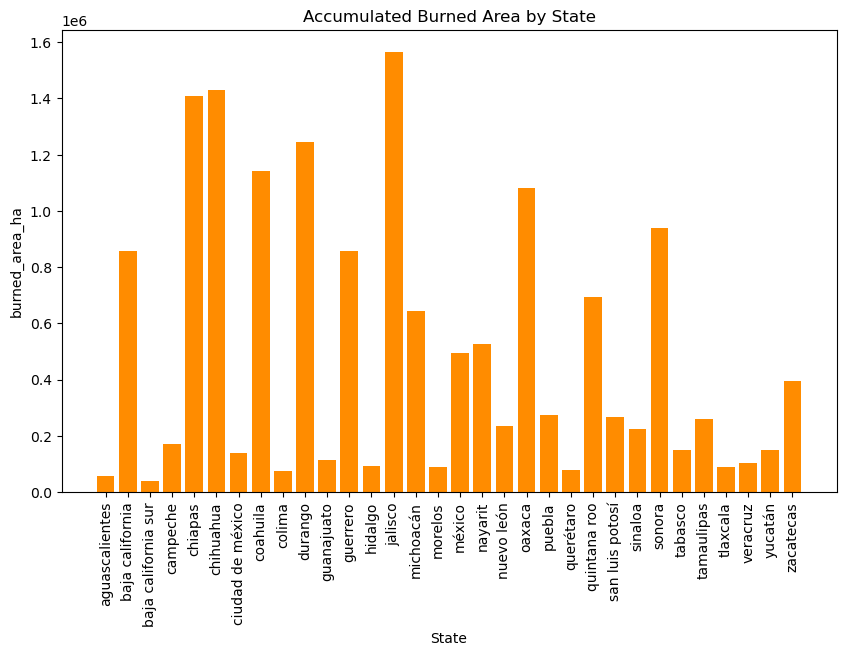

In [16]:
# Group by the state and sum the burned areas:
burned_area_per_state = wildfires_df.groupby('state')['burned_area_ha'].sum().reset_index()

bar_plot(
    burned_area_per_state['state'], 
    burned_area_per_state['burned_area_ha'],
    'State',
    'burned_area_ha',
    'Accumulated Burned Area by State'
)

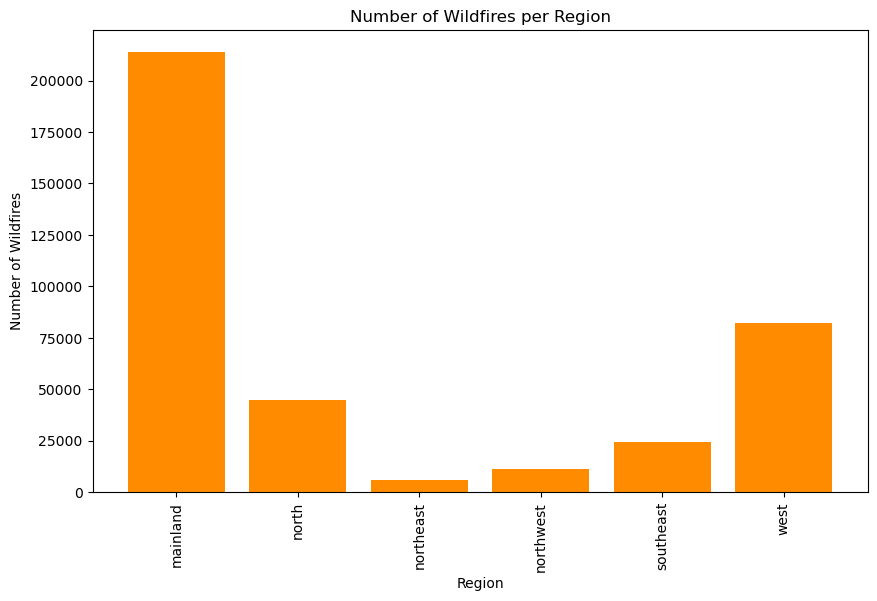

In [17]:
# Group by the region and sum the number of fires:
wildfires_per_region = wildfires_df.groupby('region')['number_of_fires'].sum().reset_index()

bar_plot(
    wildfires_per_region['region'], 
    wildfires_per_region['number_of_fires'],
    'Region',
    'Number of Wildfires',
    'Number of Wildfires per Region'
)

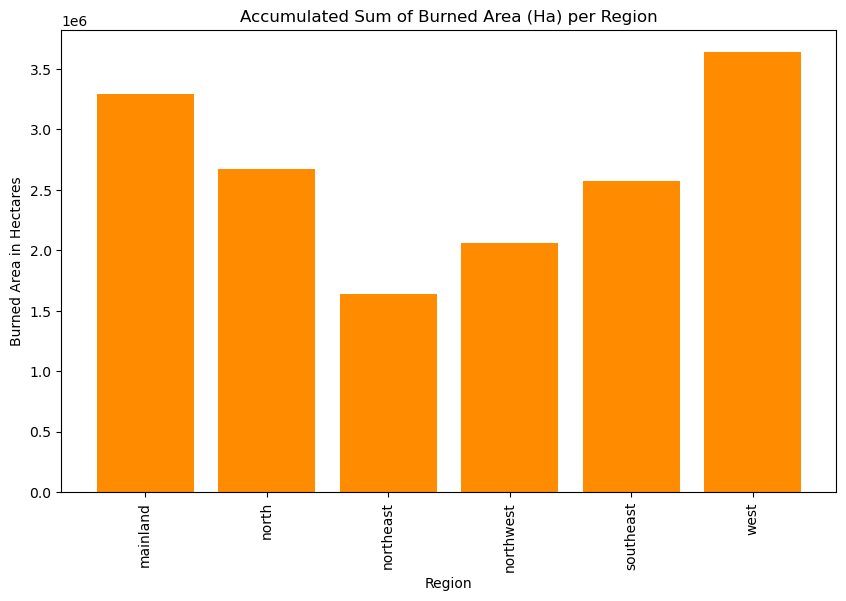

In [18]:
# Grouping burned areas per region:
burned_area_per_region = wildfires_df.groupby('region')['burned_area_ha'].sum().reset_index()

# plotting:
bar_plot(
    burned_area_per_region['region'],
    burned_area_per_region['burned_area_ha'],
    'Region',
    'Burned Area in Hectares',
    'Accumulated Sum of Burned Area (Ha) per Region'
)

## Exploratory Data Analysis 1.2 - Augmenting our dataset

For this segment, we will be using quantiles to define the different following categories:

- **Groups by number of fires:** The purpose will be to augment our dataset by adding a new categorical column that labels each state by high, medium, or low amount of fires. Since we have historical data, we want to examine how each state has behaved over the years.
- **Groups by burned area:** Likewise, we will add a new categorical column that labels each state by high, medium, or low area burned.

In [53]:
# Calculating quantiles to get a statistical measure for each group:
low_quantile = wildfires_df['number_of_fires'].quantile(0.33) ##33th quantile
high_quantile = wildfires_df['number_of_fires'].quantile(0.67) ##67th quantile

# Calculating category using quantiles:
def fires_category(number_of_fires):
    if number_of_fires <= low_quantile:
        return 'Low'
    elif low_quantile < number_of_fires <= high_quantile:
        return 'Medium'
    else:
        return 'High'
    
# Applying our categories to our dataframe in a new column:
wildfires_df['fires_amount_category'] = wildfires_df['number_of_fires'].apply(fires_category)
wildfires_df.head(5)

,year,state,number_of_fires,burned_area_ha,region,decade,fires_amount_category
0,1970,chihuahua,301,50088.0,north,1970s,High
1,1970,chiapas,97,15395.0,southeast,1970s,Medium
2,1970,guanajuato,10,12801.0,west,1970s,Low
3,1970,méxico,906,11514.0,mainland,1970s,High
4,1970,oaxaca,106,9516.0,mainland,1970s,Medium


The pandas quantile function returns values at the given quantile over the requested axis. Using the 33rd percentile (0.33) and 67th percentile (0.67) to define the quantiles is a common approach to dividing data into three roughly equal-sized groups. This method is particularly useful for categorizing data into low, medium, and high categories.

In [54]:
# Applying same process for the burned area:
low_quantile_burned_area = wildfires_df['burned_area_ha'].quantile(0.33) ##33th quantile
high_quantile_burned_area = wildfires_df['burned_area_ha'].quantile(0.67) ##67th quantile

# Applying our function again:
wildfires_df['burned_area_category'] = wildfires_df['burned_area_ha'].apply(fires_category)
wildfires_df.head(5)

,year,state,number_of_fires,burned_area_ha,region,decade,fires_amount_category,burned_area_category
0,1970,chihuahua,301,50088.0,north,1970s,High,High
1,1970,chiapas,97,15395.0,southeast,1970s,Medium,High
2,1970,guanajuato,10,12801.0,west,1970s,Low,High
3,1970,méxico,906,11514.0,mainland,1970s,High,High
4,1970,oaxaca,106,9516.0,mainland,1970s,Medium,High


## Exploratory Data Analysis 1.3 - Identifying patterns and trends


For this part we will perform some time series analysis of different categories.

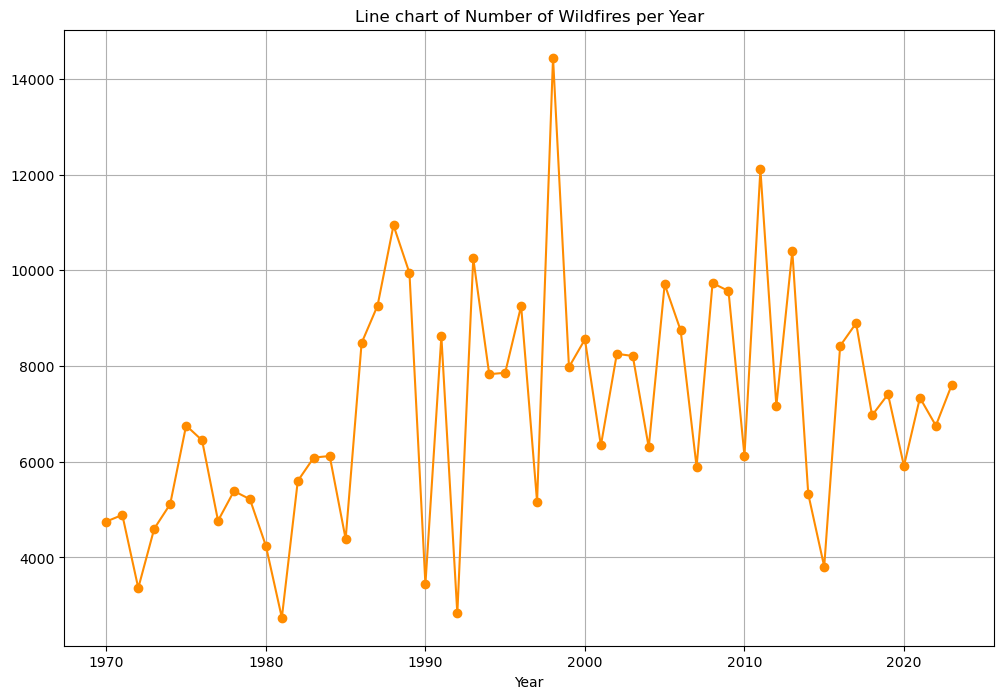

In [23]:
fires_per_year = wildfires_df.groupby('year')['number_of_fires'].sum().reset_index()

# Plotting a line chart:
plt.figure(figsize=(12, 8))
plt.plot(fires_per_year['year'], fires_per_year['number_of_fires'], marker='o',color='darkorange')
plt.title('Line chart of Number of Wildfires per Year')
plt.xlabel('Year')
plt.grid(True)

plt.show()

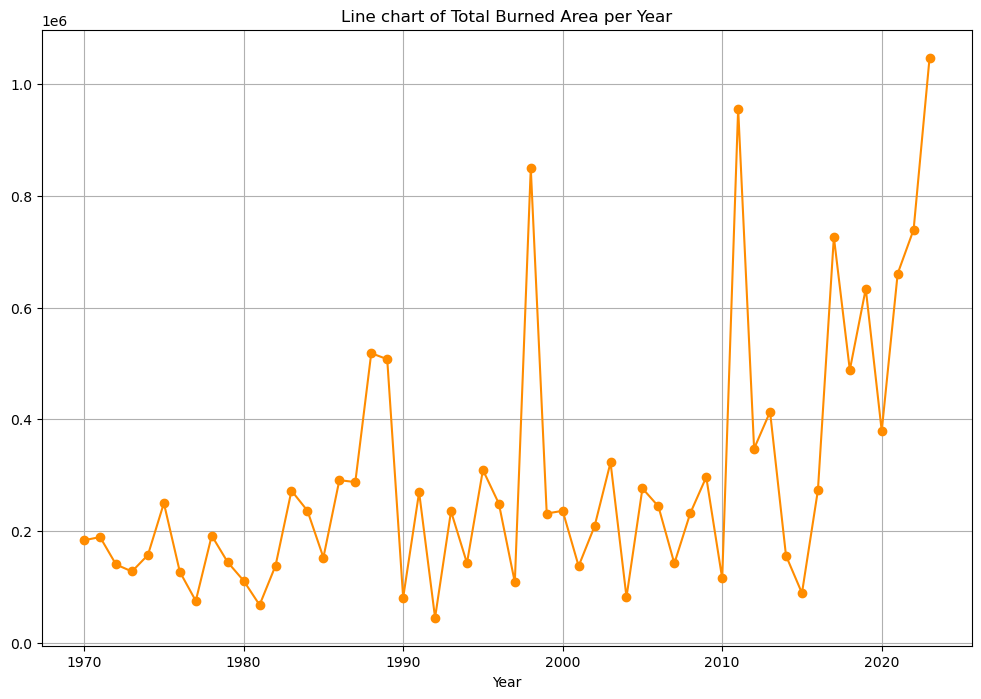

In [24]:
hectares_per_year = wildfires_df.groupby('year')['burned_area_ha'].sum().reset_index()

# Plotting a line chart:
plt.figure(figsize=(12, 8))
plt.plot(hectares_per_year['year'], hectares_per_year['burned_area_ha'], marker='o', color='darkorange')
plt.title('Line chart of Total Burned Area per Year')
plt.xlabel('Year')
plt.grid(True)

plt.show()

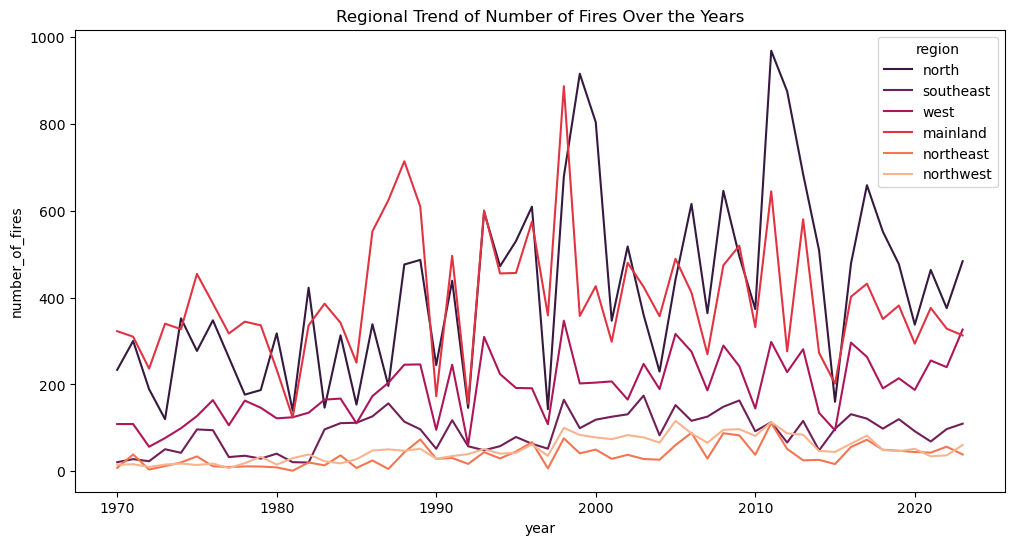

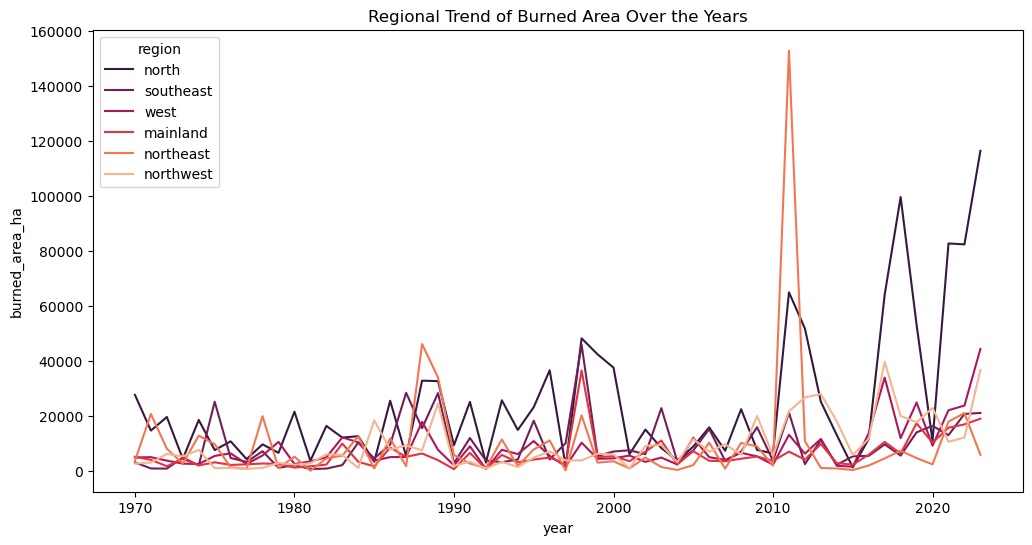

In [26]:
import seaborn as sns

# Define the colormap as a color palette:
rocket_palette = sns.color_palette("rocket", as_cmap=False, n_colors=wildfires_df['region'].nunique())

# Visualizing Regional trends:
plt.figure(figsize=(12, 6))
sns.lineplot(data=wildfires_df, x='year', y='number_of_fires', hue='region', palette=rocket_palette, errorbar=None)
plt.title('Regional Trend of Number of Fires Over the Years')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=wildfires_df, x='year', y='burned_area_ha', hue='region', palette=rocket_palette, errorbar=None)
plt.title('Regional Trend of Burned Area Over the Years')
plt.show()

## Exploratory Data Analysis 1.3 - Correlation Analysis

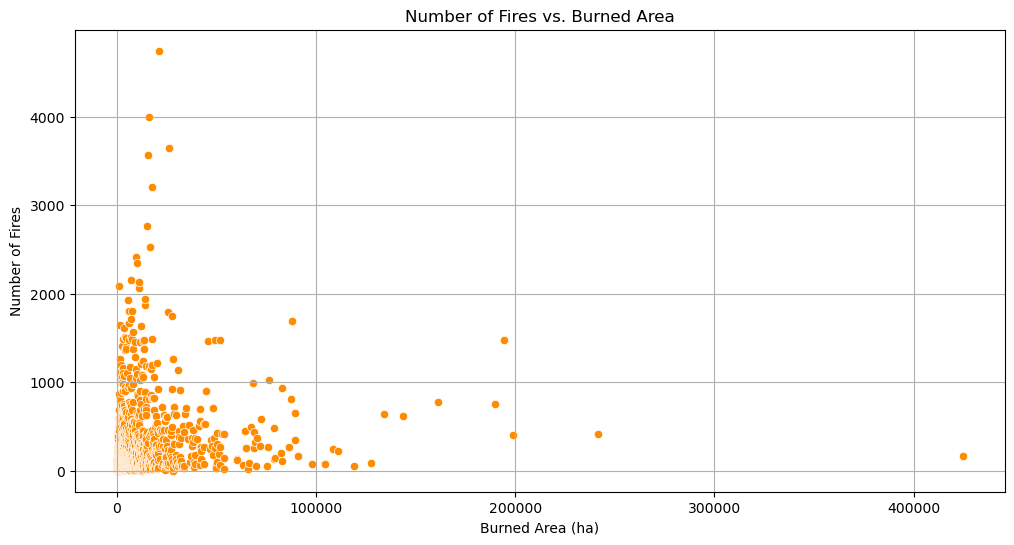

In [27]:
# Ensure your data is sorted by burned area for a meaningful line chart
df_sorted = wildfires_df.sort_values('burned_area_ha')

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_sorted, x='burned_area_ha', y='number_of_fires', marker='o', color='darkorange')
plt.xlabel('Burned Area (ha)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires vs. Burned Area')
plt.grid(True)
plt.show()

In [28]:
from scipy.stats import pearsonr

# Correlation between number of fires and burned area:
corr, _ = pearsonr(wildfires_df['number_of_fires'], wildfires_df['burned_area_ha'])
print(f'Correlation between number of fires and burned area: {corr:.2f}')

# State-specific correlations
state_corrs = wildfires_df.groupby('state').apply(lambda x: pearsonr(x['number_of_fires'], x['burned_area_ha'])[0]).reset_index()
state_corrs.columns = ['state', 'correlation']
state_corrs.sort_values('correlation', ascending = False)

Correlation between number of fires and burned area: 0.18


,state,correlation
13,jalisco,0.712928
12,hidalgo,0.710761
30,yucatán,0.692020
8,colima,0.687695
29,veracruz,0.678638
16,méxico,0.661132
25,sonora,0.626145
0,aguascalientes,0.587811
23,san luis potosí,0.585539
2,baja california sur,0.578736


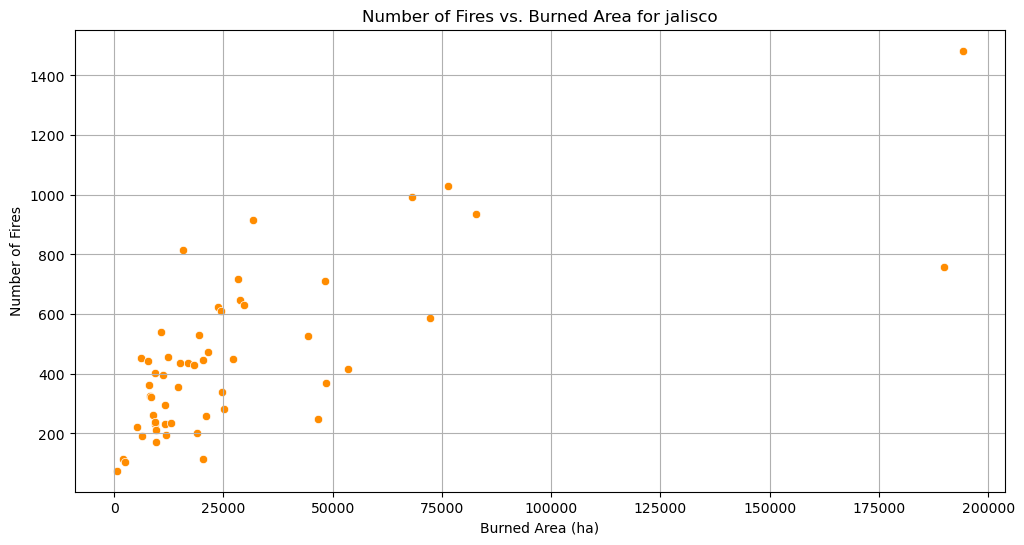

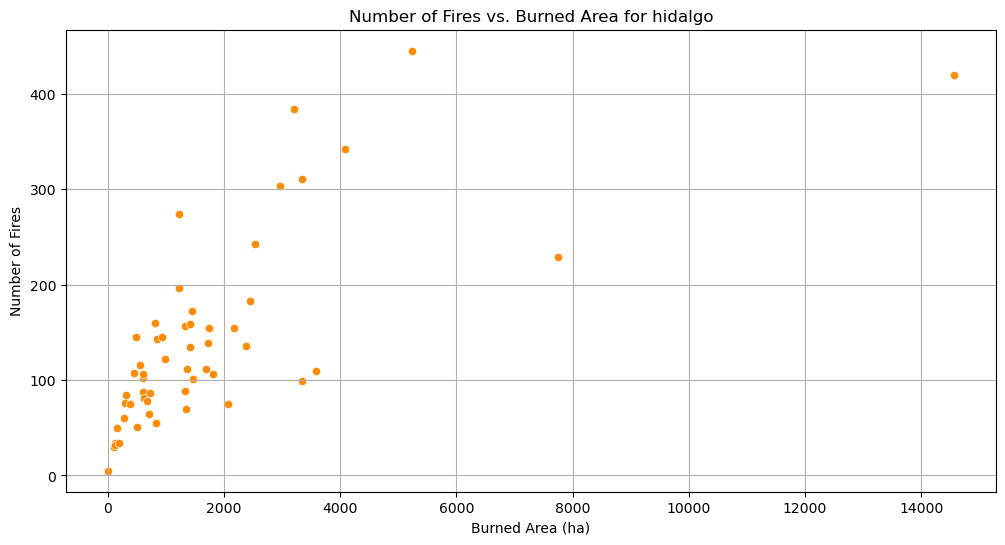

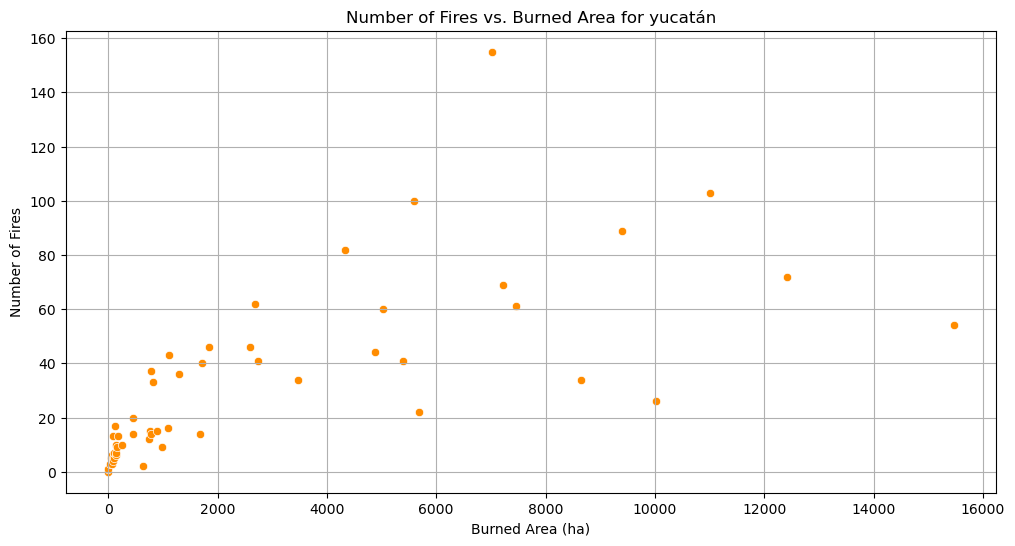

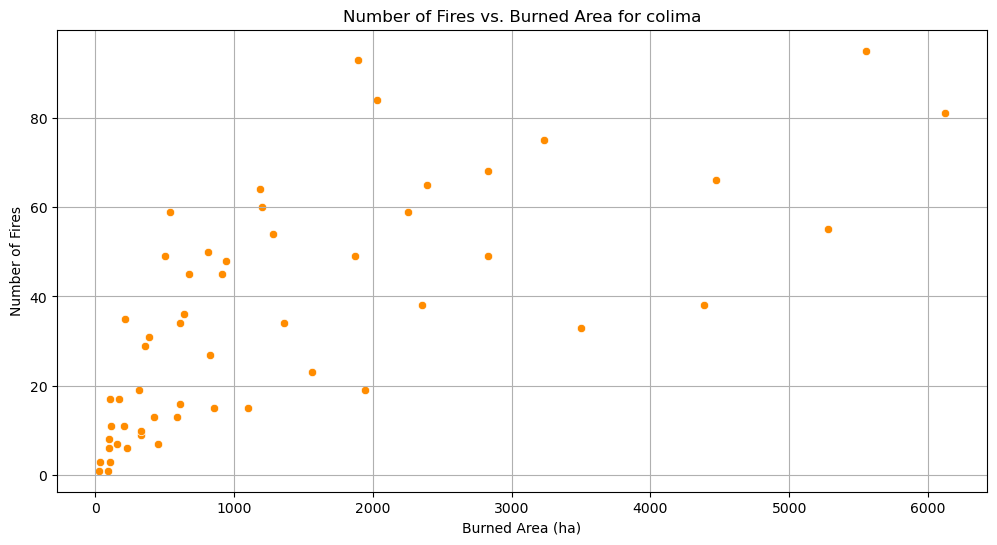

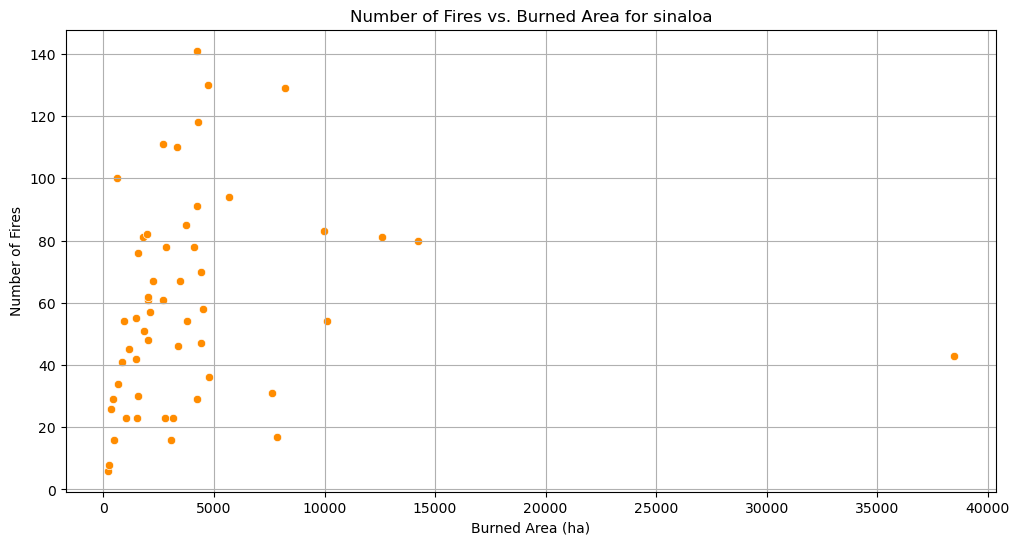

In [42]:
# creating function to plot correlation by state:

def plot_corr(df,state):
    state_df = df[df['state']==f'{state}']
    state_df_sorted = state_df.sort_values('burned_area_ha')

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=state_df_sorted, 
                    x='burned_area_ha', 
                    y='number_of_fires', 
                    marker='o', 
                    color='darkorange')
    plt.xlabel('Burned Area (ha)')
    plt.ylabel('Number of Fires')
    plt.title(f'Number of Fires vs. Burned Area for {state}')
    plt.grid(True)
    plt.show()

plot_corr(wildfires_df,'jalisco')
plot_corr(wildfires_df,'hidalgo')
plot_corr(wildfires_df,'yucatán')
plot_corr(wildfires_df,'colima')
plot_corr(wildfires_df,'sinaloa')

## Storing our file for visualization

The next step for this project is to elaborate a descripte report usign Tableau to visually analyze our data and come up with a story about wildfires in Mexico.

We will now export our final augmented dataset as a csv file and load it with tableau.

In [62]:
wildfires_df.to_csv('wildfires_mexico_data.csv')